# Week 3 Day 1. Lab 

Strictly speaking there is no lab for today. However, I wanted to share this code with you. Notice that it will collect all the Springfields in the USA. It uses  a number of interesting operations including a spatial join in order to determine the state that includes the specific Springfield highlighted on a map. I have left one optimisation for you to consider. 

The Springfields are all within the continental United States. When we view this map with Alaska, Hawaii, and Puerto Rico, this makes the continental US very small and cramped. How might we improve this figure? One way, drawing on the walkthrough, would be to crop the boundaries of the map. Another way would be to exclude these areas from the original shape file using `states_gdf = states_gdf[~states_gdf['STUSPS'].isin(['AK', 'HI', 'PR'])]`. 

- Q1. Where should we add this in the code so that it filters? Hint: it must be done in two places: `join_springfields_to_states` and `plot_springfields`. Done but only had to do it in plot_springfields

Also, notice that this code is a bit suboptimal in that it uses springfield_gdf, rather than a more generic "cities" within the methods. 

- Q2. How would you refactor this code so that it is not so tightly bound to "Springfield"? 
- Q3. Once refactored, what of this code would you place in a `*.py` file for utilities and what would you keep in the notebook? I would put all function in a .py file and keep the specific cases eg. Springfield in the .py file.

First run the code to get the map as is. It's two cells. The first is all the helper methods and the second just runs the code.


In [46]:
# Importing the required libraries
import pandas as pd
import geopandas as gpd
import requests
from shapely.geometry import Point
import re
import os
import matplotlib.pyplot as plt

# Function to fetch the content of the cities disambiguation page using the Wikipedia API
def get_disambiguation_content(cities_name:str):
    """
    Fetch the content of the cities disambiguation page using the Wikipedia API. Need to make sure citi_name is a disambiguation page.
    """
    base_url = "https://en.wikipedia.org/w/api.php"
    
    # First, get the wiki text content
    params = {
        "action": "parse",
        "page": cities_name,
        "prop": "wikitext",
        "format": "json"
    }
    
    try:
        response = requests.get(base_url, params=params) # Send GET request
        response.raise_for_status()  # Raise exception for bad status codes
        data = response.json() # Parse response as JSON
        
        if 'parse' in data and 'wikitext' in data['parse']: # Check if the expected structure is present to extract the wikitext
            return data['parse']['wikitext']['*'] # Return the wikitext content (['*'] is the key for the wikitext content)
        else:
            raise ValueError("Unexpected API response structure") 
            
    except requests.RequestException as e:
        print(f"Error fetching disambiguation page: {e}")
        return None
    
def find_headline(cities_name,string):
    ''' Function to find the headline in the content '''
    # Split content into lines as on real Wikipedia page
    content= get_disambiguation_content(cities_name)
    potential_healines=[]
    lines = content.split('\n')
    for line in lines:
        if string in line:
            potential_healines.append(line)
    return potential_healines


def parse_us_cities_from_wikitext(content, headline):
    """
    Parse US city locations from the Wikipedia wikitext content.
    Returns a list of cities locations with their state information.
    Need to make sure that headline is the name of headline after which cities in the US are listed.
    """
    cities = [] # List to store city locations
    in_us_section = False # Flag to indicate if we are in the US section
    
    # Split content into lines as on real Wikipedia page
    lines = content.split('\n') 
    
    for line in lines:
        # Check for US section start
        if headline in line:
            in_us_section = True
            continue # Skip to the next iteration of the loop
        # Check for next section (end of US section)
        elif in_us_section and line.startswith('==='):
            break # Exit the loop if we reach the end of the US section
        
        # Process lines in US section
        if in_us_section and line.strip().startswith('*'): # Check if the line starts with '*' (strip removes leading/trailing whitespace)
            # Clean up the line and extract the link
            match = re.search(r'\[\[([^\]]+)\]\]', line) # go through line and looks for the specific pattern
            if match:
                entry = match.group(1) # return first found match
                
                # Skip entries we don't want
                # if any(skip in entry for skip in ['metropolitan area', 'Township', 'CDP', 'disambiguation']):
                    # continue
                
                # Handle cases where link text differs from display text (e.g., "Springfield, Illinois|Springfield" so user sees "Springfield" but link is "Springfield, Illinois")
                if '|' in entry:
                    entry = entry.split('|')[0]
                
                # Extract city and state
                if ',' in entry:
                    location, state_info = entry.split(',', 1) # split the string at the first comma
                    state_info = state_info.strip() # remove leading/trailing whitespace
                    
                    # Handle cases with additional info in parentheses (e.g., "Springfield, Illinois (disambiguation)")
                    if '(' in state_info:
                        state_info = state_info.split('(')[0].strip() # gets rid of the parentheses and any text inside them and then removes leading/trailing whitespace
                    
                    cities.append({ # append all found cities locations to the list
                        'title': entry,
                        'city': location,
                        'state': state_info
                    })
    
    return cities

def get_coordinates_batch(cities):
    """
    Get coordinates for a list of city locations using batch requests.
    Handles both coordinate properties and coordinate templates.
    """
    base_url = "https://en.wikipedia.org/w/api.php"
    results = []
    
    # Process in batches of 50
    batch_size = 50
    for i in range(0, len(cities), batch_size): # go through the list of city locations in batches of 50
        batch = cities[i:i + batch_size] # get the next batch of 50 locations
        titles = [item['title'] for item in batch] # extract the titles from the batch
        
        # First try to get coordinates from properties (as in VW)
        params = {
            "action": "query",
            "titles": "|".join(titles),
            "prop": "coordinates|info|revisions",
            "inprop": "url",
            "rvprop": "content",
            "format": "json"
        }
        
        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()
            data = response.json()
            
            if 'query' in data and 'pages' in data['query']:
                for page_id, page in data['query']['pages'].items(): # go through the pages in the response
                    original = next((s for s in batch if s['title'] == page['title']), None) # find first entry for each title in the batch
                    if not original:
                        continue
                        
                    coordinates = None
                    
                    # Try to get coordinates from properties first
                    if 'coordinates' in page:
                        coords = page['coordinates'][0]
                        coordinates = {
                            'lat': coords['lat'],
                            'lon': coords['lon']
                        }
                    
                    # If no coordinates in properties, try to parse from content
                    elif 'revisions' in page and page['revisions']:
                        content = page['revisions'][0]['*']
                        coord_match = re.search(r'{{coord\|([^|}]+)\|([^|}]+)\|([^|}]+)\|([^|}]+)\|([^|}]+)\|([^|}]+)\|([^|}]+)\|([^|}]+)', content, re.IGNORECASE)
                        
                        if coord_match:
                            lat_deg, lat_min, lat_sec, lat_dir, lon_deg, lon_min, lon_sec, lon_dir = coord_match.groups() #extract coordintes
                            try:
                                lat = float(lat_deg) + float(lat_min)/60 + float(lat_sec)/3600
                                lon = float(lon_deg) + float(lon_min)/60 + float(lon_sec)/3600
                                
                                if lat_dir.upper() == 'S':
                                    lat = -lat
                                if lon_dir.upper() == 'W':
                                    lon = -lon
                                    
                                coordinates = {
                                    'lat': lat,
                                    'lon': lon
                                }
                            except ValueError:
                                continue
                    
                    if coordinates:
                        results.append({
                            'title': page['title'],
                            'city': original['city'],
                            'state': original['state'],
                            'latitude': coordinates['lat'],
                            'longitude': coordinates['lon'],
                            'url': page.get('canonicalurl', '')
                        })
                            
        except requests.RequestException as e:
            print(f"Error in batch coordinate request: {e}")
            continue
    
    return pd.DataFrame(results)

def create_cities_geodataframe(cities_name:str,headline):
    """
    Main function to create a GeoDataFrame of US cities
    """
    # Get disambiguation page content
    print(f"Fetching {cities_name} disambiguation page...")
    content = get_disambiguation_content(cities_name)
    
    if content is None:
        raise ValueError("Failed to fetch disambiguation page content")
    
    # Parse US cities
    print(f"Parsing {cities_name} locations...")
    cities = parse_us_cities_from_wikitext(content,headline)
    print(f"Found {len(cities)} {cities_name} locations in US")
    
    # Get coordinates
    print("Fetching coordinates...")
    cities_df = get_coordinates_batch(cities)
    print(f"Successfully retrieved coordinates for {len(cities_df)} locations")
    
    # Create GeoDataFrame
    geometry = [Point(xy) for xy in zip(cities_df['longitude'], cities_df['latitude'])]
    cities_gdf = gpd.GeoDataFrame(cities_df, geometry=geometry, crs="EPSG:4326")
    
    return cities_gdf

def main(cities_name:str, headline): 
    ''' Main function to create a GeoDataFrame of US cities and display/save the results '''
    try:
        # Create GeoDataFrame
        cities_df = create_cities_geodataframe(cities_name, headline)
        
        # Display results
        print(f"\n{cities_name} locations with coordinates:")
        print(cities_df[['city', 'state', 'latitude', 'longitude']])
        
        # Optionally save to file
        cities_df.to_file("cities.geojson", driver='GeoJSON')
        
        return cities_df
        
    except Exception as e:
        print(f"Error in main execution: {e}")
        return None

def join_cities_to_states(cities_gdf):
    """
    Perform spatial join between cities and US states shapefile,
    handling column name conflicts properly
    """
    # Download and prepare US states shapefile
    url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip"
    
    if not os.path.exists('data'):
        os.makedirs('data')
    
    zip_path = "data/us_states.zip"
    if not os.path.exists(zip_path):
        print("Downloading US states data...")
        response = requests.get(url)
        with open(zip_path, 'wb') as f:
            f.write(response.content)
    
    # Read states shapefile
    states_gdf = gpd.read_file(f"zip://{zip_path}")
    states_gdf = states_gdf.to_crs(cities_gdf.crs) # use name coordinates as cities_gdf
        
    # Rename columns in states_gdf to avoid conflicts
    states_gdf = states_gdf.rename(columns={
        'NAME': 'state_name',
        'STUSPS': 'state_abbrev'
    })
    
    # Before joining, rename original state column if it exists
    if 'state' in cities_gdf.columns:
        cities_gdf = cities_gdf.rename(columns={'state': 'state_from_wiki'})
    
    # Perform spatial join
    joined = gpd.sjoin(
        cities_gdf,
        states_gdf[['state_name', 'state_abbrev', 'geometry']],
        how='left',
        predicate='within'
    )
    
    # Validate and clean up the results
    joined['state_match'] = joined.apply(
        lambda x: x['state_from_wiki'].strip() == x['state_name'].strip() 
        if pd.notnull(x['state_from_wiki']) and pd.notnull(x['state_name']) # checks if value in column is notnull
        else False,
        axis=1
    )
    
    # Print any mismatches for verification
    mismatches = joined[~joined['state_match']] # get all rows where state_match is False (~ is a negation operator)
    if not mismatches.empty:
        print("\nFound state name mismatches:")
        print(mismatches[['title', 'state_from_wiki', 'state_name', 'state_abbrev']])
    
    return joined

def plot_cities(joined_gdf,cities_name,save_path=None, remove_states=[]):
    """
    Create a map of cities with state highlighting. 
    Remove states from the map if needed (eg. Alaska (AK), Hawaii (HI), Puerto Rico (PR) since may make continental US map look small).
    """
    # Download states shapefile if not done already
    url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip"
    zip_path = "data/us_states.zip"
    states_gdf = gpd.read_file(f"zip://{zip_path}")

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plot all states in light gray
    states_gdf = states_gdf[~states_gdf['STUSPS'].isin(remove_states)] # remove_states
    states_gdf.plot(ax=ax, color='lightgray', edgecolor='white')
    
    # Get unique states that have cities
    states_with_cities = joined_gdf['state_name'].unique()
    
    # Highlight states with cities    
    states_gdf[states_gdf['NAME'].isin(states_with_cities)].plot(
        ax=ax, color='lightblue', edgecolor='white'
    )
    
    # Plot cities points
    joined_gdf.plot(ax=ax, color='red', markersize=50)
    
    # Add labels for each city
    for idx, row in joined_gdf.iterrows():
        ax.annotate(
            f"{row['city']}, {row['state_abbrev']}",
            xy=(row.geometry.x, row.geometry.y),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=8,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
        )
    
    ax.set_title(f'US Cities Named {cities_name}', fontsize=14)
    plt.axis('off')
    
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Map saved to {save_path}")
    
    return fig, ax

def analyze_cities_distribution(joined_gdf,cities_name):
    """
    Analyze the distribution of cities across states
    """
    # Count cities per state
    state_counts = joined_gdf.groupby(['state_name', 'state_abbrev']).size().reset_index(name='count')
    state_counts = state_counts.sort_values('count', ascending=False)
    
    print(f"\n{cities_name} Distribution by State \n{state_counts}")
    print(state_counts)
    
    return state_counts



Fetching Springfield disambiguation page...
Parsing Springfield locations...
Found 50 Springfield locations in US
Fetching coordinates...
Successfully retrieved coordinates for 40 locations

Found state name mismatches:
                                             title  \
0          Springfield, Albemarle County, Virginia   
4              Springfield, Dane County, Wisconsin   
9           Springfield, Jackson County, Wisconsin   
11            Springfield, LaPorte County, Indiana   
14        Springfield, Marquette County, Wisconsin   
24              Springfield, Page County, Virginia   
25              Springfield, Posey County, Indiana   
28        Springfield, St. Croix County, Wisconsin   
31         Springfield, Walworth County, Wisconsin   
33      Springfield, Westmoreland County, Virginia   
34         Springfield/Belmont, Newark, New Jersey   
37             Springfield (Coatesville, Virginia)   
39  Springfield Township, Oakland County, Michigan   

                  state

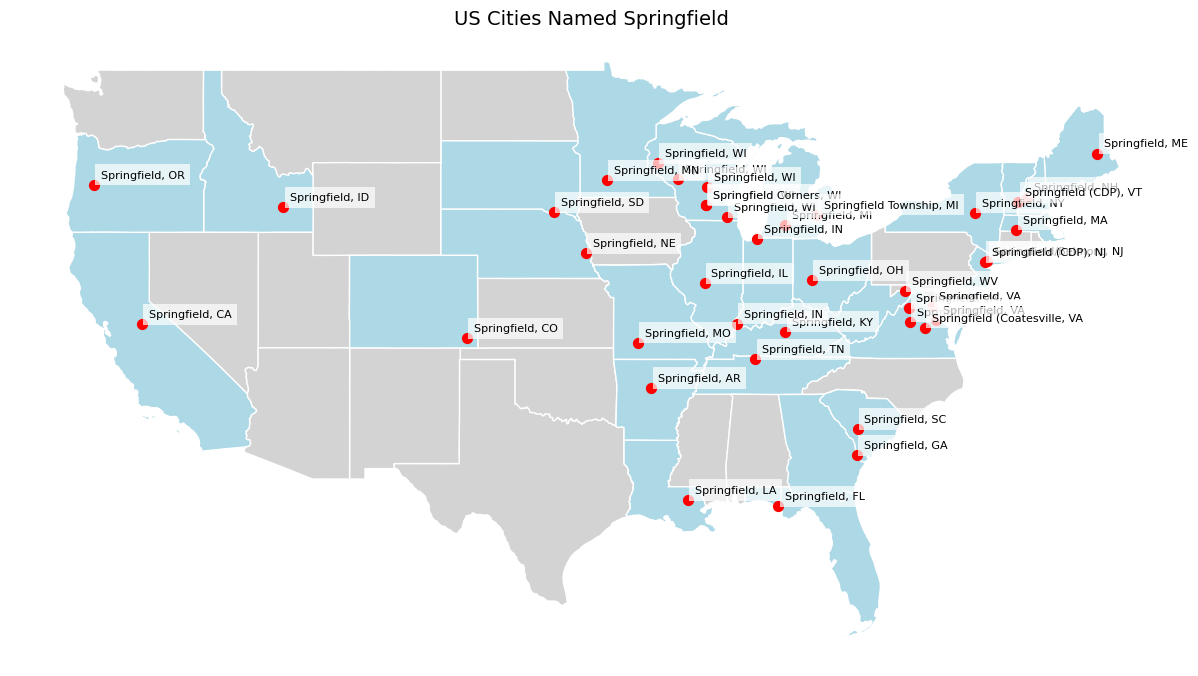

In [48]:
cities_name="Springfield"
headline="== United States =="

cities_gdf = create_cities_geodataframe(cities_name,headline)
    
# Perform spatial join with states
joined_gdf = join_cities_to_states(cities_gdf)
    
# Analyze distribution
state_counts = analyze_cities_distribution(joined_gdf, cities_name)

# Create and save map
fig, ax = plot_cities(joined_gdf, cities_name, save_path=f'figures/{cities_name}_map.png',remove_states=["AK","HI","PR"])

Fetching Washington disambiguation page...
Parsing Washington locations...
Found 32 Washington locations in US
Fetching coordinates...
Successfully retrieved coordinates for 27 locations

Washington Distribution by State 
        state_name state_abbrev  count
2       California           CA      2
0          Alabama           AL      1
1         Arkansas           AR      1
3      Connecticut           CT      1
4          Georgia           GA      1
5         Illinois           IL      1
6          Indiana           IN      1
7             Iowa           IA      1
8           Kansas           KS      1
9        Louisiana           LA      1
10           Maine           ME      1
11     Mississippi           MS      1
12        Missouri           MO      1
13        Nebraska           NE      1
14   New Hampshire           NH      1
15        New York           NY      1
16  North Carolina           NC      1
17            Ohio           OH      1
18        Oklahoma           OK      

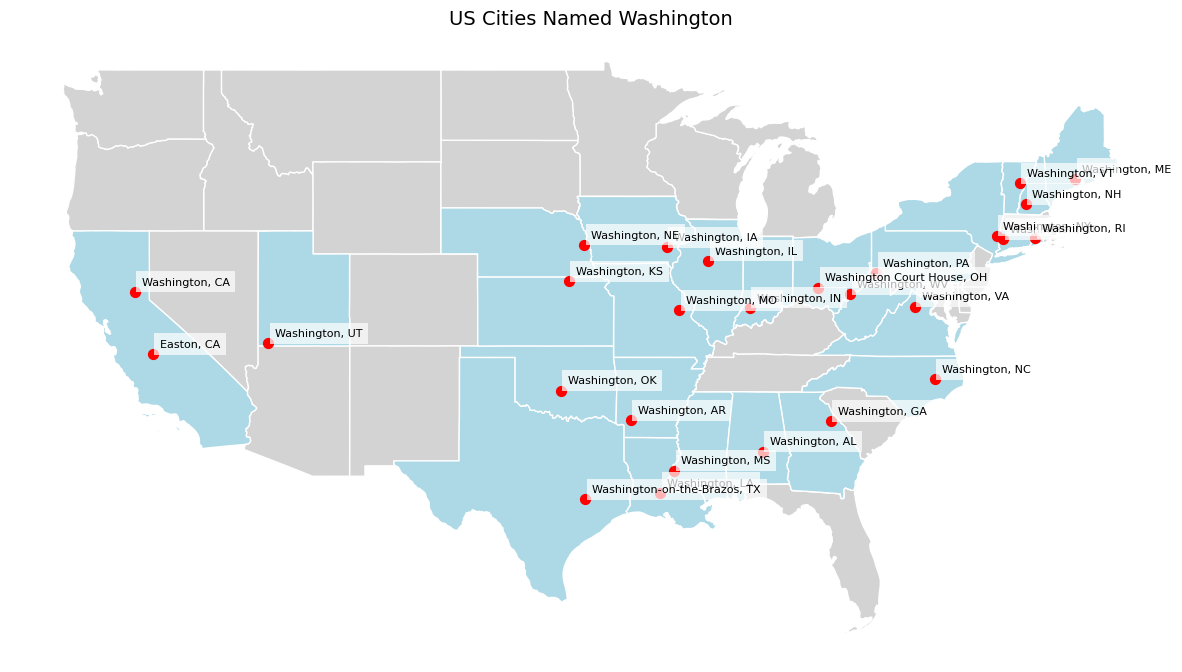

In [32]:
cities_name="Washington"

headline = "====Cities and communities===="


cities_gdf = create_cities_geodataframe(cities_name,headline)
    
# Perform spatial join with states
joined_gdf = join_cities_to_states(cities_gdf)
    
# Analyze distribution
state_counts = analyze_cities_distribution(joined_gdf, cities_name)

# Create and save map
fig, ax = plot_cities(joined_gdf, cities_name, save_path=f'figures/{cities_name}_map.png',remove_states=["AK","HI","PR"])

Fetching Franklin disambiguation page...
Parsing Franklin locations...
Found 33 Franklin locations in US
Fetching coordinates...
Successfully retrieved coordinates for 26 locations

Found state name mismatches:
                               title         state_from_wiki state_name  \
3   Franklin, Douglas County, Kansas  Douglas County, Kansas     Kansas   
24   Franklin, Wayne County, Indiana   Wayne County, Indiana    Indiana   

   state_abbrev  
3            KS  
24           IN  

Franklin Distribution by State 
        state_name state_abbrev  count
6          Indiana           IN      2
8           Kansas           KS      2
2      Connecticut           CT      1
0          Alabama           AL      1
3          Georgia           GA      1
4            Idaho           ID      1
5         Illinois           IL      1
1         Arkansas           AR      1
7             Iowa           IA      1
9         Kentucky           KY      1
10       Louisiana           LA      1
11      

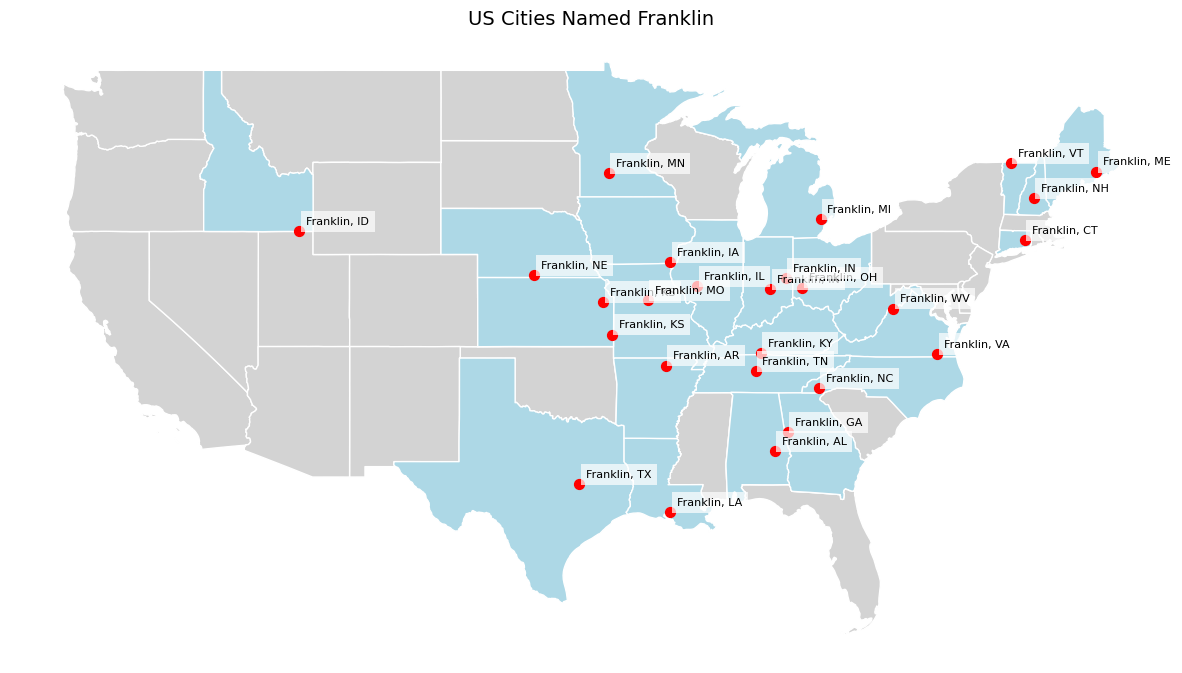

In [33]:
cities_name="Franklin"

headline = "== United States =="


cities_gdf = create_cities_geodataframe(cities_name,headline)
    
# Perform spatial join with states
joined_gdf = join_cities_to_states(cities_gdf)
    
# Analyze distribution
state_counts = analyze_cities_distribution(joined_gdf, cities_name)

# Create and save map
fig, ax = plot_cities(joined_gdf, cities_name, save_path=f'figures/{cities_name}_map.png',remove_states=["AK","HI","PR"])

In [47]:
cities_name="Chester (disambiguation)"

find_headline(cities_name,"United States")

['===United States===']

Fetching Chester (disambiguation) disambiguation page...
Parsing Chester (disambiguation) locations...
Found 36 Chester (disambiguation) locations in US
Fetching coordinates...
Successfully retrieved coordinates for 35 locations

Found state name mismatches:
                               title          state_from_wiki state_name  \
18  Chester, Orange County, New York  Orange County, New York   New York   
25  Chester, Warren County, New York  Warren County, New York   New York   
30     Chester (Homeville, Virginia)                Virginia)   Virginia   

   state_abbrev  
18           NY  
25           NY  
30           VA  

Chester (disambiguation) Distribution by State 
        state_name state_abbrev  count
19    Pennsylvania           PA      4
16        New York           NY      3
10   Massachusetts           MA      2
24        Virginia           VA      2
23         Vermont           VT      2
5         Illinois           IL      1
4            Idaho           ID      1
2  

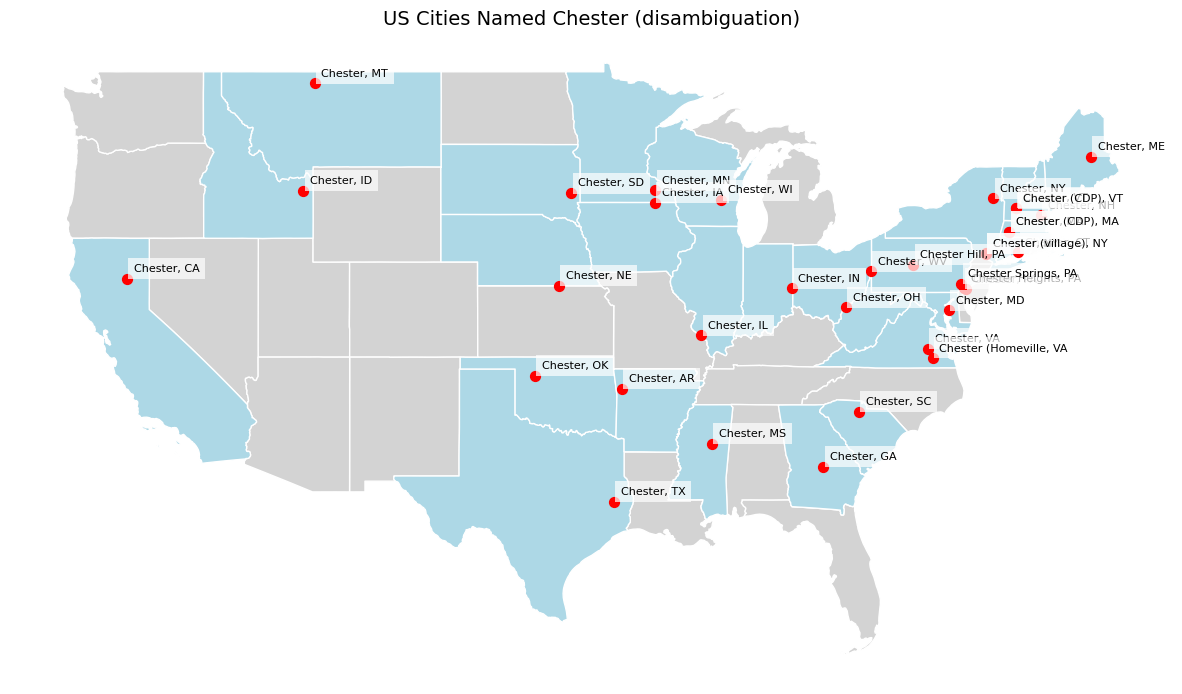

In [45]:
cities_name="Chester (disambiguation)"

headline = "===United States==="

cities_gdf = create_cities_geodataframe(cities_name,headline)
    
# Perform spatial join with states
joined_gdf = join_cities_to_states(cities_gdf)
    
# Analyze distribution
state_counts = analyze_cities_distribution(joined_gdf, cities_name)

# Create and save map
fig, ax = plot_cities(joined_gdf, cities_name, save_path=f'figures/{cities_name}_map.png',remove_states=["AK","HI","PR"])

The map looks very cramped. In order to make it more clear we might want to filter to the continental United States. Here is an example image when filtered correctly:

<img src="figures/springfields_map_example.png" alt="Springfields Map Example" />
